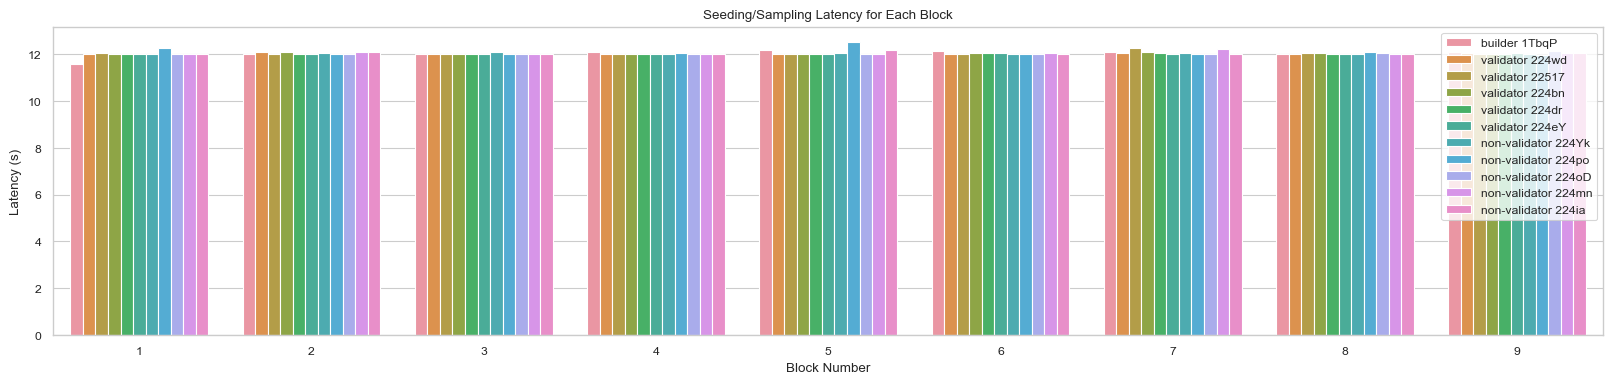

In [80]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def merge_nonbuilder_latencies(latency_files, node_type):
    """
    Merge all validator latency files into one dataframe
    """
    
    latency_dfs = []
    for latency_file in latency_files:
        latency_df = pd.read_csv(latency_file)
        latency_df['filename'] = latency_file.replace("_latency_stats_" +node_type+ ".csv", "")
        latency_df["node_type"] = node_type
        latency_df['block_id'] = range(len(latency_df))
        latency_df = latency_df[ ["node_type", "filename", "block_id", "Total Sampling Latency (us)"] ]
        
        latency_dfs.append(latency_df)

    return pd.concat(latency_dfs)

def get_nonbuilder_df(latency_files, node_type):
    latency_df = merge_nonbuilder_latencies(latency_files, node_type)
    latency_df['Latency (s)'] = latency_df['Total Sampling Latency (us)'] / 1_000_000
    latency_df = latency_df[ ["node_type", "filename", "block_id", "Latency (s)"] ]

    return latency_df

def get_latency_files(node_type):
    if node_type == "builder":
        return [file for file in os.listdir() if file.endswith('builder.csv') and "latency_stats" in file.lower()][0]
    else:
        return [file for file in os.listdir() if file.endswith('_' +node_type+ '.csv') and "latency_stats" in file.lower()]

builder_latency_file = get_latency_files("builder")
validator_latency_files = get_latency_files("validator")
non_validator_latency_files = get_latency_files("nonvalidator")

validator_latency_df = get_nonbuilder_df(validator_latency_files, "validator")
non_validator_latency_df = get_nonbuilder_df(non_validator_latency_files, "non-validator")

# Get builder latency stats
builder_latency_df = pd.read_csv(builder_latency_file)
builder_latency_df['Latency (s)'] = builder_latency_df['Seeding Latency (us)'] / 1_000_000
builder_latency_df['filename'] = builder_latency_file.replace("_latency_stats_builder.csv", "")
builder_latency_df['block_id'] = range(len(builder_latency_df))
builder_latency_df["node_type"] = "builder"
builder_latency_df = builder_latency_df[ ["node_type", "filename", "block_id", "Latency (s)"] ]

# Merge all latency stats
latency_df = pd.concat([builder_latency_df, validator_latency_df, non_validator_latency_df])
latency_df['node_label'] = latency_df['node_type'] + " " + latency_df['filename'].apply(lambda x: x[:5])

# Remove first and last block
latency_df = latency_df[ (latency_df['block_id'] != 0) & (latency_df['block_id'] != len(builder_latency_df) - 1) ]

# Plot multi bar chart of latency for each block
sns.set_style("whitegrid")
sns.set_context("paper")
plt.figure(figsize=(20, 4))
plt.title("Seeding/Sampling Latency for Each Block")
sns.barplot(x="block_id", y="Latency (s)", hue="node_label", data=latency_df)
plt.xlabel("Block Number")
plt.ylabel("Latency (s)")
plt.legend()
plt.show()
plt.close()